# 深度学习模型
特征：
1. 滑动窗口采样
设置windows size，采样前k个step预测下一个

2. 滑动窗口平均采样

模型：
1. MLP
2. CNN
3. LSTM
4. RCNN
5. RWKV

todo：
1. 加入额外特征embedding

In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import math
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
from dataclasses import dataclass

In [3]:
import torch

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
device

'cuda:0'

# 1 读取处理后数据

字典数据：
```
{
    'tid':[
        [cycle_count],
        [battery_life]
    ]
}
```

DataFrame数据：
```
columns = [tid,cycle_count,life]
```

In [6]:
bmap = pickle.load(open("../data/processed/nasa-li-battery_dict_240906.pkl",'rb'))

In [7]:
# ddf = pd.read_pickle('../data/processed/nasa-li-battery_df_240906.pkl')

# 2 特征采样和评价指标

## 2.1 特征采样

In [8]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

## 2.2 训练和评价

In [9]:
from tqdm import tqdm

### 绘图函数

In [10]:
def plot(name,
         real_data, 
         pred_data):
    fig, ax = plt.subplots(1, figsize=(12, 8))

    plot_range = [i for i in range(len(real_data))]
    
    ax.plot(plot_range, real_data, 'b.', label=name)
    ax.plot(plot_range, pred_data, 'r.', label='Prediction')
    plt.plot([-1,170],[2*0.7, 2*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()

# 3 RNN

RNN取最后一个step接linear输出。

后续可考虑LSTM和attention。

In [11]:
from typing import List,Dict,Tuple

In [12]:
from collections import OrderedDict

In [13]:
import torch

In [14]:
class NASALiBatteryDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 fpath:str,
                ):
        
        x_lst,y_lst = [],[]
        self.data_dict = pickle.load(open(fpath,'rb'))
        for name in self.data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(self.data_dict, name, window_size)
            real_train_y = np.expand_dims(train_y[:,-1],-1)
            x_lst.append(train_x)
            y_lst.append(real_train_y)
        self.train_x = np.vstack(x_lst)
        self.train_y = np.vstack(y_lst)
        
    def __len__(self):
        return self.train_x.shape[0]
        
    def __getitem__(self, indices):
        
        return np.take(self.train_x,axis=0,indices=indices), np.take(self.train_y,axis=0,indices=indices)

In [15]:
class BaseModel(torch.nn.Module):

    def __init__(self, 
                 prefix_length:int=1,
                 device:str='cpu'):
        super(BaseModel, self).__init__()
        
        self.prefix_length = prefix_length
        self.device = device
    def __post_init__(self):
        self.double()
        
    def decode(self,
               input_x:np.array,
               max_length:int):
        '''
        input_x: List(prefix_length, )
        max_length: target decode length
        '''
        if not self.prefix_length != len(input_x):
            assert(f'Error input sequence must be prefix_length shape:{self.prefix_length}')

        test_x = input_x
        
        # decode to target length
        for i in range(max_length+1):
            online_x = np.array(test_x[-self.prefix_length:])
            online_x = torch.tensor(online_x).reshape((1,online_x.shape[0])).double().to(self.device)
            test_x += self.forward(online_x).cpu().flatten().detach().numpy().tolist() #测试值加入原来序列用来继续预测下一个点

        # list
        return test_x
        
    def forward(self, 
                x:torch.Tensor):
        '''
        x: (prefix_length, )
        '''
        pass

In [16]:
class RNNATTModel(BaseModel):

    def __init__(self,
                 feature_size:int,
                 qk_dim:int,
                 v_dim:int,
                 model_type:str='rnn',
                 num_layers:int=1,
                 prefix_length:int=1,
                 device:str='cpu'):
        super(RNNATTModel, self).__init__(
            prefix_length=prefix_length,
               device=device
        )
        self.feature_size = feature_size
        self.qk_dim = qk_dim
        self.v_dim = v_dim
        # 只有一个channel 所以默认input_size和hidden_size为1，没啥需要设置的参数
        self.RNNLayer = torch.nn.RNN(input_size=1,
                                                hidden_size=self.prefix_length,
                                                num_layers=num_layers,
                                                batch_first=True,
                                                dropout=0.5,
                                                bidirectional=False)
        if model_type == 'gru':
            self.RNNLayer = torch.nn.GRU(input_size=1,
                                                hidden_size=self.prefix_length,
                                                num_layers=num_layers,
                                                batch_first=True,
                                                dropout=0.5,
                                                bidirectional=False)
        elif model_type == 'lstm':
            self.RNNLayer = torch.nn.LSTM(input_size=1,
                                                hidden_size=self.prefix_length,
                                                num_layers=num_layers,
                                                batch_first=True,
                                                dropout=0.5,
                                                bidirectional=False)
        
        self.wq = torch.nn.Parameter(torch.rand((self.qk_dim,self.feature_size)))
        self.wk = torch.nn.Parameter(torch.rand((self.qk_dim,self.feature_size)))
        self.wv = torch.nn.Parameter(torch.rand((self.v_dim,self.feature_size)))
        
        self.OutLinearLayer = torch.nn.Linear(in_features=self.prefix_length,
                                              out_features=1)
        
        self.__post_init__()

    def SelfAttention(self,
                      x:torch.Tensor):
        
        kval = x.matmul(self.wk.T)
        qval = x.matmul(self.wq.T)
        vval = x.matmul(self.wv.T)

        omega = qval.matmul(torch.einsum('ijk->ikj',kval))
        
        omega = omega/np.sqrt(self.qk_dim)
        
        omega = torch.nn.functional.softmax(omega,1)
        
        att_out = omega.matmul(vval)
        
        pool_out = torch.nn.AvgPool1d(kernel_size=self.v_dim)(att_out).squeeze()

        return pool_out
        
    def forward(self,
                x:torch.Tensor):
        x = x.reshape(x.shape[0],x.shape[1],1)
        
        out, _ = self.RNNLayer(x)       # out shape: (batch_size, feature_size, hidden_dim)
        self_out = self.SelfAttention(out)
        y = self.OutLinearLayer(self_out)      # out shape: (batch_size, 1)
        
        return y

In [17]:
window_size = 32
epoch = 10_00_000
learning_rate = 1e-4    # learning rate
weight_decay = 0.0
feature_size = 32
qk_dim = 32
v_dim = 16
num_layers = 2
batch_size = 512
model_type = 'lstm'

In [18]:
eval_step = 1000

In [19]:
data_dict = bmap

In [20]:
model = RNNATTModel(feature_size=feature_size,
                    model_type=model_type,
                 qk_dim=qk_dim,
                    v_dim=v_dim,
                    num_layers=num_layers,
                 prefix_length=window_size,
                   device=device)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [22]:
model.to(device)

RNNATTModel(
  (RNNLayer): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.5)
  (OutLinearLayer): Linear(in_features=32, out_features=1, bias=True)
)

In [23]:
on_test_log = True

In [24]:
train_dataset = NASALiBatteryDataset(fpath='../data/processed/nasa-li-battery_dict_240906.pkl')

In [25]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

In [26]:
loss_list = [0]
mae_lst,rmse_lst = [], []

for i in tqdm(range(epoch)):
    if i%eval_step==0 and on_test_log:
        print('---------------------------------------------------')
    for batch_x,batch_y in train_loader:
        model.train()
        output= model(batch_x.to(device))
        loss = criterion(output, batch_y.to(device))
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        loss_list.append(loss.cpu().detach().numpy().tolist())

    if i%eval_step==0:
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            
            prefix_x = data_dict[name][1][:window_size]
            decode_seq = model.decode(prefix_x,max_length=len(test_data))[window_size+1:]
            mae, rmse = evaluation(y_test=test_data, y_predict=decode_seq)
            
            mae_lst.append(mae)
            rmse_lst.append(rmse)
        
        if on_test_log:
            print(f'Epoch:{i} Loss:{np.average(loss_list):.8f} MAE:{np.average(mae_lst):.4f} | RMSE:{np.average(rmse_lst):.4f}')

  0%|                                                                                      | 0/1000000 [00:00<?, ?it/s]

---------------------------------------------------


  0%|                                                                          | 2/1000000 [00:01<226:12:55,  1.23it/s]

Epoch:0 Loss:1.78725605 MAE:1.5480 | RMSE:1.5545


  0%|                                                                        | 1000/1000000 [03:28<58:08:17,  4.77it/s]

---------------------------------------------------


  0%|                                                                       | 1001/1000000 [03:30<204:37:09,  1.36it/s]

Epoch:1000 Loss:0.07510438 MAE:0.8045 | RMSE:0.8122


  0%|▏                                                                       | 2000/1000000 [06:59<58:58:31,  4.70it/s]

---------------------------------------------------


  0%|▏                                                                      | 2001/1000000 [07:01<209:09:57,  1.33it/s]

Epoch:2000 Loss:0.03836627 MAE:0.5573 | RMSE:0.5650


  0%|▏                                                                       | 3000/1000000 [10:29<57:44:39,  4.80it/s]

---------------------------------------------------


  0%|▏                                                                      | 3002/1000000 [10:31<154:56:00,  1.79it/s]

Epoch:3000 Loss:0.02594939 MAE:0.4309 | RMSE:0.4384


  0%|▎                                                                       | 4000/1000000 [13:59<57:09:14,  4.84it/s]

---------------------------------------------------


  0%|▎                                                                      | 4001/1000000 [14:01<185:54:32,  1.49it/s]

Epoch:4000 Loss:0.01967013 MAE:0.3572 | RMSE:0.3645


  0%|▎                                                                       | 5000/1000000 [17:27<57:11:06,  4.83it/s]

---------------------------------------------------


  1%|▎                                                                      | 5002/1000000 [17:29<152:09:39,  1.82it/s]

Epoch:5000 Loss:0.01587809 MAE:0.3067 | RMSE:0.3140


  1%|▍                                                                       | 6000/1000000 [20:56<57:06:34,  4.83it/s]

---------------------------------------------------


  1%|▍                                                                      | 6001/1000000 [20:58<193:10:48,  1.43it/s]

Epoch:6000 Loss:0.01333833 MAE:0.2702 | RMSE:0.2775


  1%|▌                                                                       | 7000/1000000 [24:25<57:01:32,  4.84it/s]

---------------------------------------------------


  1%|▍                                                                      | 7002/1000000 [24:27<148:19:37,  1.86it/s]

Epoch:7000 Loss:0.01151678 MAE:0.2446 | RMSE:0.2520


  1%|▌                                                                       | 8000/1000000 [27:53<57:01:31,  4.83it/s]

---------------------------------------------------


  1%|▌                                                                      | 8001/1000000 [27:55<195:45:55,  1.41it/s]

Epoch:8000 Loss:0.01014567 MAE:0.2216 | RMSE:0.2291


  1%|▋                                                                       | 9000/1000000 [31:22<57:04:15,  4.82it/s]

---------------------------------------------------


  1%|▋                                                                      | 9002/1000000 [31:24<150:22:35,  1.83it/s]

Epoch:9000 Loss:0.00907598 MAE:0.2036 | RMSE:0.2110


  1%|▋                                                                      | 10000/1000000 [34:51<57:06:45,  4.82it/s]

---------------------------------------------------


  1%|▋                                                                     | 10002/1000000 [34:53<148:54:36,  1.85it/s]

Epoch:10000 Loss:0.00821793 MAE:0.1893 | RMSE:0.1967


  1%|▊                                                                      | 11000/1000000 [38:20<56:59:03,  4.82it/s]

---------------------------------------------------


  1%|▊                                                                     | 11001/1000000 [38:22<185:56:19,  1.48it/s]

Epoch:11000 Loss:0.00751391 MAE:0.1765 | RMSE:0.1839


  1%|▊                                                                      | 12000/1000000 [41:49<56:56:09,  4.82it/s]

---------------------------------------------------


  1%|▊                                                                     | 12001/1000000 [41:51<189:20:40,  1.45it/s]

Epoch:12000 Loss:0.00692586 MAE:0.1733 | RMSE:0.1812


  1%|▉                                                                      | 13000/1000000 [45:19<57:02:43,  4.81it/s]

---------------------------------------------------


  1%|▉                                                                     | 13002/1000000 [45:21<151:02:40,  1.82it/s]

Epoch:13000 Loss:0.00642724 MAE:0.1681 | RMSE:0.1763


  1%|▉                                                                      | 14000/1000000 [48:48<56:45:04,  4.83it/s]

---------------------------------------------------


  1%|▉                                                                     | 14002/1000000 [48:50<148:38:23,  1.84it/s]

Epoch:14000 Loss:0.00599890 MAE:0.1605 | RMSE:0.1687


  2%|█                                                                      | 15000/1000000 [52:18<56:47:59,  4.82it/s]

---------------------------------------------------


  2%|█                                                                     | 15001/1000000 [52:19<188:33:30,  1.45it/s]

Epoch:15000 Loss:0.00562662 MAE:0.1549 | RMSE:0.1633


  2%|█▏                                                                     | 16000/1000000 [55:47<56:46:43,  4.81it/s]

---------------------------------------------------


  2%|█                                                                     | 16002/1000000 [55:49<147:07:51,  1.86it/s]

Epoch:16000 Loss:0.00529996 MAE:0.1479 | RMSE:0.1563


  2%|█▏                                                                     | 17000/1000000 [59:17<56:42:07,  4.82it/s]

---------------------------------------------------


  2%|█▏                                                                    | 17001/1000000 [59:18<189:38:40,  1.44it/s]

Epoch:17000 Loss:0.00501116 MAE:0.1438 | RMSE:0.1525


  2%|█▏                                                                   | 18000/1000000 [1:02:46<57:39:01,  4.73it/s]

---------------------------------------------------


  2%|█▏                                                                  | 18001/1000000 [1:02:48<190:15:37,  1.43it/s]

Epoch:18000 Loss:0.00475396 MAE:0.1394 | RMSE:0.1481


  2%|█▎                                                                   | 19000/1000000 [1:06:16<56:27:46,  4.83it/s]

---------------------------------------------------


  2%|█▎                                                                  | 19002/1000000 [1:06:18<148:14:48,  1.84it/s]

Epoch:19000 Loss:0.00452346 MAE:0.1344 | RMSE:0.1431


  2%|█▍                                                                   | 20000/1000000 [1:09:45<56:29:56,  4.82it/s]

---------------------------------------------------


  2%|█▎                                                                  | 20001/1000000 [1:09:47<185:28:06,  1.47it/s]

Epoch:20000 Loss:0.00431565 MAE:0.1297 | RMSE:0.1383


  2%|█▍                                                                   | 21000/1000000 [1:13:15<56:26:48,  4.82it/s]

---------------------------------------------------


  2%|█▍                                                                  | 21002/1000000 [1:13:17<149:54:02,  1.81it/s]

Epoch:21000 Loss:0.00412734 MAE:0.1255 | RMSE:0.1341


  2%|█▌                                                                   | 22000/1000000 [1:16:45<56:23:17,  4.82it/s]

---------------------------------------------------


  2%|█▍                                                                  | 22002/1000000 [1:16:47<150:13:44,  1.81it/s]

Epoch:22000 Loss:0.00395590 MAE:0.1215 | RMSE:0.1300


  2%|█▌                                                                   | 23000/1000000 [1:20:14<56:18:39,  4.82it/s]

---------------------------------------------------


  2%|█▌                                                                  | 23001/1000000 [1:20:16<191:38:34,  1.42it/s]

Epoch:23000 Loss:0.00379917 MAE:0.1199 | RMSE:0.1288


  2%|█▋                                                                   | 24000/1000000 [1:23:44<56:18:28,  4.81it/s]

---------------------------------------------------


  2%|█▋                                                                  | 24002/1000000 [1:23:46<148:39:54,  1.82it/s]

Epoch:24000 Loss:0.00365528 MAE:0.1169 | RMSE:0.1258


  2%|█▋                                                                   | 25000/1000000 [1:27:15<57:25:13,  4.72it/s]

---------------------------------------------------


  3%|█▋                                                                  | 25001/1000000 [1:27:17<198:07:49,  1.37it/s]

Epoch:25000 Loss:0.00352278 MAE:0.1139 | RMSE:0.1228


  3%|█▊                                                                   | 26000/1000000 [1:30:48<56:37:26,  4.78it/s]

---------------------------------------------------


  3%|█▊                                                                  | 26001/1000000 [1:30:50<193:47:58,  1.40it/s]

Epoch:26000 Loss:0.00340031 MAE:0.1130 | RMSE:0.1220


  3%|█▊                                                                   | 27000/1000000 [1:34:20<56:38:00,  4.77it/s]

---------------------------------------------------


  3%|█▊                                                                  | 27002/1000000 [1:34:23<172:27:06,  1.57it/s]

Epoch:27000 Loss:0.00328680 MAE:0.1103 | RMSE:0.1193


  3%|█▉                                                                   | 28000/1000000 [1:37:53<56:41:22,  4.76it/s]

---------------------------------------------------


  3%|█▉                                                                  | 28001/1000000 [1:37:55<203:37:13,  1.33it/s]

Epoch:28000 Loss:0.00318129 MAE:0.1078 | RMSE:0.1167


  3%|██                                                                   | 29000/1000000 [1:41:26<56:50:02,  4.75it/s]

---------------------------------------------------


  3%|█▉                                                                  | 29001/1000000 [1:41:28<206:35:54,  1.31it/s]

Epoch:29000 Loss:0.00308292 MAE:0.1062 | RMSE:0.1153


  3%|██                                                                   | 30000/1000000 [1:44:59<56:28:45,  4.77it/s]

---------------------------------------------------


  3%|██                                                                  | 30001/1000000 [1:45:01<198:42:25,  1.36it/s]

Epoch:30000 Loss:0.00299102 MAE:0.1046 | RMSE:0.1137


  3%|██▏                                                                  | 31000/1000000 [1:48:31<56:22:31,  4.77it/s]

---------------------------------------------------


  3%|██                                                                  | 31002/1000000 [1:48:33<155:36:33,  1.73it/s]

Epoch:31000 Loss:0.00290499 MAE:0.1029 | RMSE:0.1120


  3%|██▏                                                                  | 32000/1000000 [1:52:04<56:56:56,  4.72it/s]

---------------------------------------------------


  3%|██▏                                                                 | 32001/1000000 [1:52:06<194:00:51,  1.39it/s]

Epoch:32000 Loss:0.00282426 MAE:0.1021 | RMSE:0.1113


  3%|██▎                                                                  | 33000/1000000 [1:55:36<56:22:28,  4.76it/s]

---------------------------------------------------


  3%|██▏                                                                 | 33002/1000000 [1:55:39<156:35:24,  1.72it/s]

Epoch:33000 Loss:0.00274833 MAE:0.1003 | RMSE:0.1095


  3%|██▎                                                                  | 34000/1000000 [1:59:11<57:03:51,  4.70it/s]

---------------------------------------------------


  3%|██▎                                                                 | 34002/1000000 [1:59:14<150:44:52,  1.78it/s]

Epoch:34000 Loss:0.00267681 MAE:0.0986 | RMSE:0.1078


  4%|██▍                                                                  | 35000/1000000 [2:02:44<56:28:22,  4.75it/s]

---------------------------------------------------


  4%|██▍                                                                 | 35001/1000000 [2:02:46<204:15:29,  1.31it/s]

Epoch:35000 Loss:0.00260932 MAE:0.0990 | RMSE:0.1083


  4%|██▍                                                                  | 36000/1000000 [2:06:17<56:38:08,  4.73it/s]

---------------------------------------------------


  4%|██▍                                                                 | 36001/1000000 [2:06:19<189:26:59,  1.41it/s]

Epoch:36000 Loss:0.00254553 MAE:0.0975 | RMSE:0.1069


  4%|██▌                                                                  | 37000/1000000 [2:09:50<57:23:09,  4.66it/s]

---------------------------------------------------


  4%|██▌                                                                 | 37001/1000000 [2:09:52<193:55:26,  1.38it/s]

Epoch:37000 Loss:0.00248515 MAE:0.0969 | RMSE:0.1064


  4%|██▌                                                                  | 38000/1000000 [2:13:24<57:14:09,  4.67it/s]

---------------------------------------------------


  4%|██▌                                                                 | 38001/1000000 [2:13:26<211:17:40,  1.26it/s]

Epoch:38000 Loss:0.00242789 MAE:0.0960 | RMSE:0.1054


  4%|██▋                                                                  | 39000/1000000 [2:16:57<55:56:15,  4.77it/s]

---------------------------------------------------


  4%|██▋                                                                 | 39001/1000000 [2:16:59<211:19:04,  1.26it/s]

Epoch:39000 Loss:0.00237354 MAE:0.0943 | RMSE:0.1037


  4%|██▊                                                                  | 40000/1000000 [2:20:30<55:55:46,  4.77it/s]

---------------------------------------------------


  4%|██▋                                                                 | 40002/1000000 [2:20:32<158:23:00,  1.68it/s]

Epoch:40000 Loss:0.00232186 MAE:0.0930 | RMSE:0.1024


  4%|██▊                                                                  | 41000/1000000 [2:24:03<58:27:32,  4.56it/s]

---------------------------------------------------


  4%|██▊                                                                 | 41001/1000000 [2:24:05<212:07:39,  1.26it/s]

Epoch:41000 Loss:0.00227267 MAE:0.0920 | RMSE:0.1013


  4%|██▉                                                                  | 42000/1000000 [2:27:36<56:30:35,  4.71it/s]

---------------------------------------------------


  4%|██▊                                                                 | 42001/1000000 [2:27:38<216:20:11,  1.23it/s]

Epoch:42000 Loss:0.00222579 MAE:0.0911 | RMSE:0.1003


  4%|██▉                                                                  | 43000/1000000 [2:31:09<55:55:41,  4.75it/s]

---------------------------------------------------


  4%|██▉                                                                 | 43002/1000000 [2:31:11<147:28:20,  1.80it/s]

Epoch:43000 Loss:0.00218104 MAE:0.0910 | RMSE:0.1004


  4%|███                                                                  | 44000/1000000 [2:34:42<55:44:58,  4.76it/s]

---------------------------------------------------


  4%|██▉                                                                 | 44001/1000000 [2:34:44<192:08:37,  1.38it/s]

Epoch:44000 Loss:0.00213832 MAE:0.0899 | RMSE:0.0993


  4%|███                                                                  | 45000/1000000 [2:38:15<55:49:51,  4.75it/s]

---------------------------------------------------


  5%|███                                                                 | 45001/1000000 [2:38:17<197:00:11,  1.35it/s]

Epoch:45000 Loss:0.00209745 MAE:0.0890 | RMSE:0.0984


  5%|███▏                                                                 | 46000/1000000 [2:41:49<55:37:22,  4.76it/s]

---------------------------------------------------


  5%|███▏                                                                | 46001/1000000 [2:41:51<189:59:35,  1.39it/s]

Epoch:46000 Loss:0.00205834 MAE:0.0879 | RMSE:0.0973


  5%|███▏                                                                 | 47000/1000000 [2:45:22<55:27:43,  4.77it/s]

---------------------------------------------------


  5%|███▏                                                                | 47001/1000000 [2:45:24<200:23:14,  1.32it/s]

Epoch:47000 Loss:0.00202085 MAE:0.0869 | RMSE:0.0963


  5%|███▎                                                                 | 48000/1000000 [2:48:55<55:39:52,  4.75it/s]

---------------------------------------------------


  5%|███▎                                                                | 48001/1000000 [2:48:57<208:10:01,  1.27it/s]

Epoch:48000 Loss:0.00198491 MAE:0.0862 | RMSE:0.0956


  5%|███▎                                                                 | 48722/1000000 [2:51:31<55:48:55,  4.73it/s]


KeyboardInterrupt: 

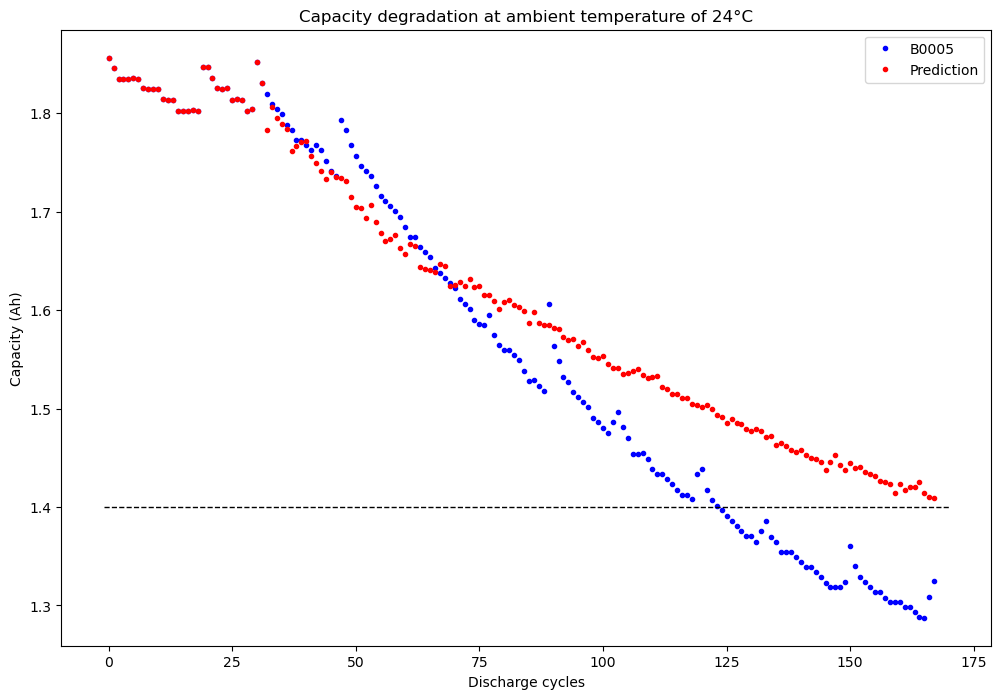

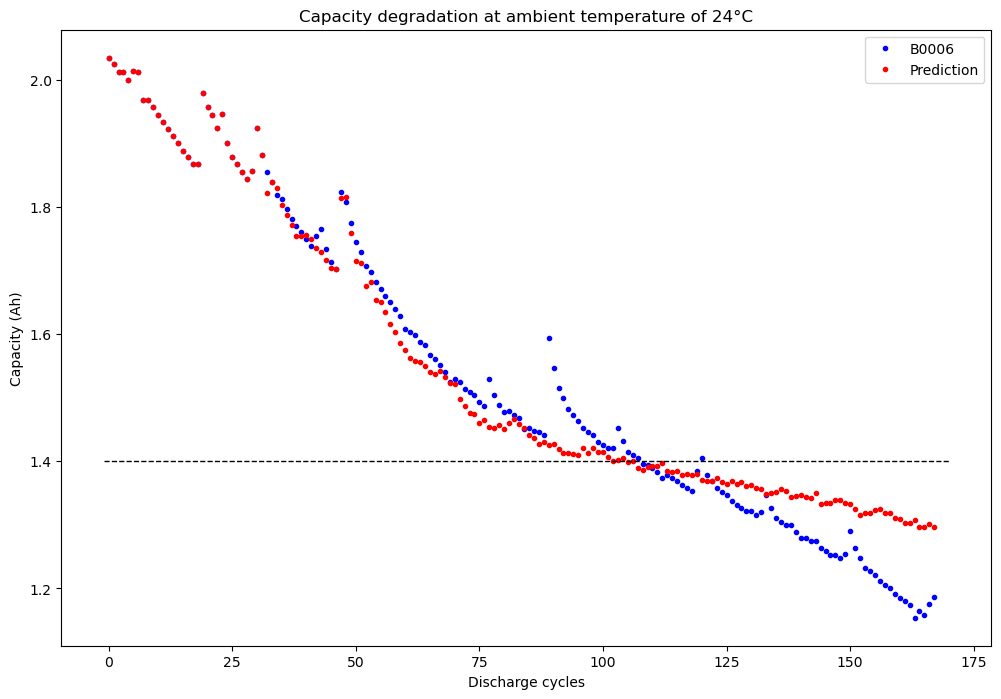

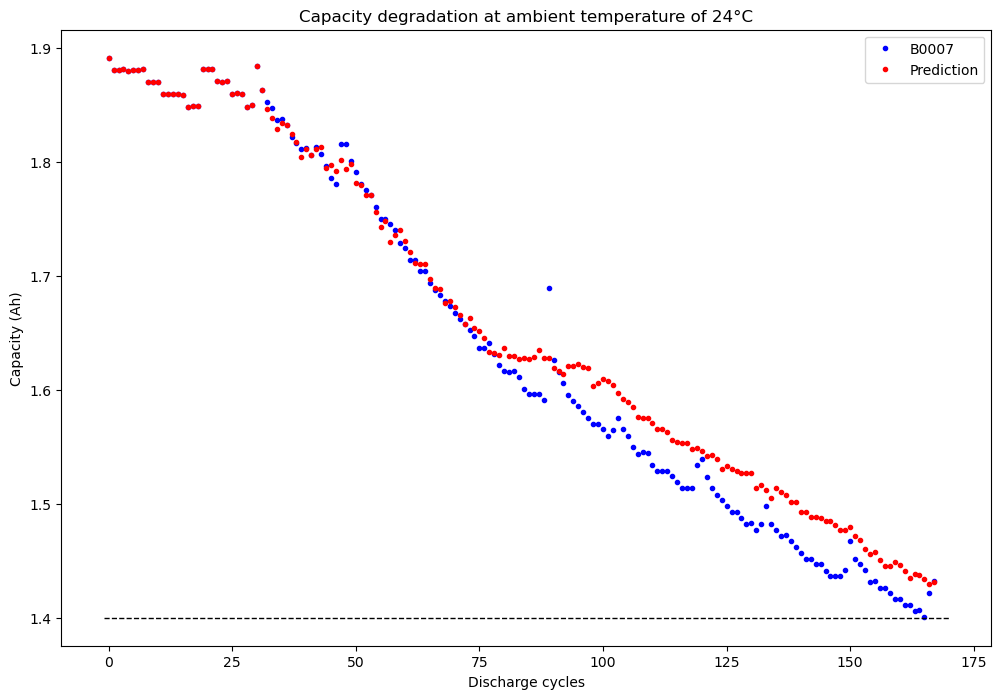

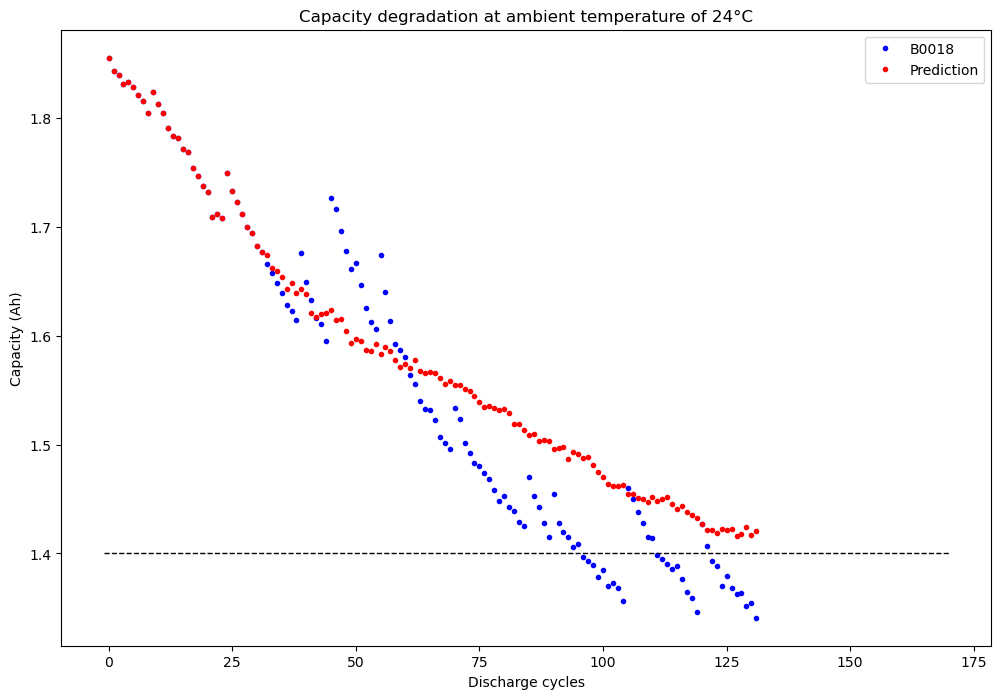

In [27]:
for name in data_dict.keys():
    train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)

    real = data_dict[name][1]
    prefix_x = data_dict[name][1][:window_size]
    decode_seq = model.decode(prefix_x,max_length=len(test_data))
    
    plot(name=name,
         real_data=real,
        pred_data=decode_seq)

In [28]:
if not os.path.isdir('../data/model'):
    os.mkdir('../data/model')

In [30]:
torch.save(model,f'../data/model/{model_type}_att_240917.bin')